In [1]:
#!pip install numba

In [2]:
import pandas as pd
import numpy as np
import data_handler as dh
import model as md
import time
import matplotlib.pyplot as plt
from matplotlib import rc
import pickle

In [3]:
import importlib
importlib.reload(dh)
importlib.reload(md)

<module 'model' from '/var/local/nvarenik/traffic_flows/TransportNet/Stable Dynamic & Beckman/model.py'>

In [4]:
import numba
numba.__version__

'0.54.1'

In [5]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)
from platform import python_version
print('python', python_version())
print('numpy', np.__version__)
print('pandas', pd.__version__)
import graph_tool
print('graph_tool', graph_tool.__version__)

/usr/bin/python3
3.9.5 (default, May 24 2021, 12:50:35) 
[GCC 11.1.0]
sys.version_info(major=3, minor=9, micro=5, releaselevel='final', serial=0)
python 3.9.5
numpy 1.20.3
pandas 1.2.5
graph_tool 2.42 (commit 458bd492, Fri Jul 2 22:11:01 2021 +0200)


# Beckmann model

parameter $\mu = 0.25$

In [6]:
import os

beckmann_save = 'init_results'
if not os.path.exists(beckmann_save):
    os.makedirs(beckmann_save)

In [7]:
net_name = 'Anaheim_net.tntp'
trips_name = 'Anaheim_trips.tntp'

handler = dh.DataHandler()
graph_data = handler.GetGraphData(net_name, columns = ['init_node', 'term_node', 'capacity', 'free_flow_time'])
graph_correspondences, total_od_flow = handler.GetGraphCorrespondences(trips_name)

model = md.Model(graph_data, graph_correspondences, 
                    total_od_flow, mu = 0.25, rho = 0.15)

graph_data['graph_table'].head()

,init_node,init_node_thru,term_node,term_node_thru,capacity,free_flow_time
0,1,False,117,True,9000.0,1.090458
1,2,False,87,True,9000.0,1.090458
2,3,False,74,True,9000.0,1.090458
3,4,False,233,True,9000.0,1.090458
4,5,False,165,True,9000.0,1.090458


In [8]:
answer = handler.ReadAnswer('Anaheim_flow.tntp')
t_star = np.array(answer['times'])
t_free_flow = graph_data['graph_table']['free_flow_time'].values

## 1. Experiments with different starting points

Let $t^*$ be times related to an optimal solution, while $t_{FF}$ is free flow times.<br/>
The dependence of convergence on a starting point is studied for various algorithms in the following experiments.<br/>
The set $T$ of considered starting points is given as
$$T = \{ \gamma t_{FF} + (1-\gamma) t^* | \gamma \in [0, 1] \}.$$
Specifically, the parameter $\gamma$ is chosen from $[0.2, 0.36, 0.52, 0.68, 0.84, 1.0]$.<br/>
Therefore, for $t \in T \,\, R = \| t^* − t \|_2 = \| \gamma(t^* − t_{FF}) \|_2 = \gamma \|(t^* − t_{FF})  \|_2 = \gamma R_{FF}$.

In [9]:
gammas = np.linspace(0.2, 1, 6)

### Frank-Wolfe method

In [17]:
#new prox oracle etc. t_weighted !!
assert(model.mu == 0.25)
print('Frank-Wolfe without stopping criteria')
max_iter = 1000#10000
init_results = {}

for gamma in gammas:
    print('Gamma = {:.2f}'.format(gamma))
    t_start = gamma * t_free_flow + (1 - gamma) * t_star
    solver_kwargs = {'max_iter' : max_iter, 'stop_crit': 'max_iter',
                     'verbose' : True, 'verbose_step': 2000, 'save_history' : True}
    tic = time.time()
    result = model.find_equilibrium(solver_name = 'fwm', solver_kwargs = solver_kwargs, t_start=t_start)
    init_results[gamma] = result
    toc = time.time()
    print('Elapsed time: {:.0f} sec'.format(toc - tic))
    print('Time ratio =', np.max(result['times'] / graph_data['graph_table']['free_flow_time']))
    print('Flow excess =', np.max(result['flows'] / graph_data['graph_table']['capacity']) - 1)
    print('-'*50)

Frank-Wolfe without stopping criteria
Gamma = 0.20
Oracles created...
Frank-Wolfe method...
Given point is used as t_start...
Primal_init = 1.28701e+06
Dual_init = -1.28475e+06
Duality_gap_init = 2254.71

Result: success
Total iters: 1000
Primal_func_value = 1.28603e+06
Dual_func_value = -1.28603e+06
Duality_gap = 1.16118
Duality_gap / Duality_gap_init = 0.000515004
Oracle elapsed time: 24 sec
Elapsed time: 24 sec
Time ratio = 3.300126035242004
Flow excess = 0.9789346109446093
--------------------------------------------------
Gamma = 0.36
Oracles created...
Frank-Wolfe method...
Given point is used as t_start...
Primal_init = 1.28722e+06
Dual_init = -1.2822e+06
Duality_gap_init = 5013.49

Result: success
Total iters: 1000
Primal_func_value = 1.28603e+06
Dual_func_value = -1.28603e+06
Duality_gap = 1.15831
Duality_gap / Duality_gap_init = 0.000231039
Oracle elapsed time: 23 sec
Elapsed time: 24 sec
Time ratio = 3.3001268315382606
Flow excess = 0.9789346109446093
-----------------------

In [25]:
with open('init_results/beckmann_anaheim_fwm_res_1000.pickle', 'wb') as f:
    pickle.dump(init_results, f) 

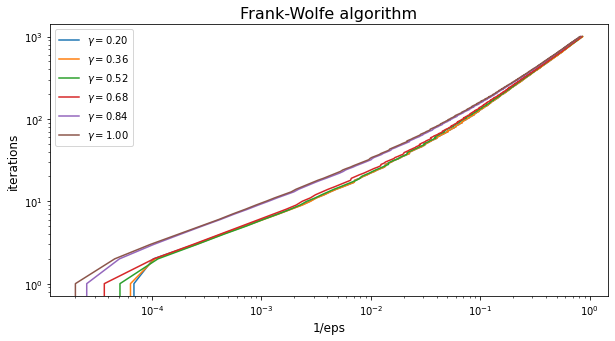

In [198]:
plt.figure(figsize = (10, 5))
for gamma in gammas:
    result = init_results[gamma]
    dual_gaps = np.array(result['history']['dual_gap'])
    iters = np.array(result['history']['iter'])
    plt.plot(1/dual_gaps, iters, label='$\gamma=${:.2f}'.format(gamma))
    plt.title('Frank-Wolfe algorithm', fontsize = 16)
    plt.xlabel('1/eps', fontsize = 12)
    plt.ylabel('iterations', fontsize = 12)
    plt.xscale('log')
    plt.yscale('log')
plt.legend();

## Universal Similar Triangles

In [11]:
epsilons = np.hstack([np.logspace(4, 3, 5)[:-1], np.logspace(3, -0.5, 8)])[::-1]
epsilons

array([3.16227766e-01, 1.00000000e+00, 3.16227766e+00, 1.00000000e+01,
       3.16227766e+01, 1.00000000e+02, 3.16227766e+02, 1.00000000e+03,
       1.77827941e+03, 3.16227766e+03, 5.62341325e+03, 1.00000000e+04])

In [12]:
assert(model.mu == 0.25)

init_results = {}
max_iter = 1000
for gamma in gammas:
    print('Gamma = {:.2f}'.format(gamma))
    t_start = gamma * t_free_flow + (1 - gamma) * t_star
    results = []
    for index, eps_abs in enumerate(epsilons):
        print('eps_abs =', eps_abs)
        solver_kwargs = {'eps_abs': eps_abs,
                         'max_iter': max_iter, 'stop_crit': 'dual_gap',
                         'verbose' : True, 'verbose_step': 2000, 'save_history' : True}
        tic = time.time()
        result = model.find_equilibrium(
            solver_name = 'ustm', 
            composite = True, 
            solver_kwargs = solver_kwargs,
            t_start=t_start,
        )
        toc = time.time()
        print('Elapsed time: {:.0f} sec'.format(toc - tic))
        print('Time ratio =', np.max(result['times'] / graph_data['graph_table']['free_flow_time']))
        print('Flow excess =', np.max(result['flows'] / graph_data['graph_table']['capacity']) - 1, end = '\n\n')

        result['eps_abs'] = eps_abs
        result['elapsed_time'] = toc - tic
        results.append(result)
    init_results[gamma] = results
    print('-'*50)

Gamma = 0.20
eps_abs = 0.31622776601683794
Composite optimization...
Oracles created...
Universal similar triangles method...
Given point is used as t_start...
Primal_init = 1.28701e+06
Dual_init = -1.28475e+06
Duality_gap_init = 2254.71

Result: iterations number exceeded
Total iters: 1000
Primal_func_value = 1.28614e+06
Dual_func_value = -1.28572e+06
Duality_gap = 425.513
Duality_gap / Duality_gap_init = 0.188722
Oracle elapsed time: 62 sec
Elapsed time: 63 sec
Time ratio = 2.9608706231248254
Flow excess = 1.1187571141771353

eps_abs = 1.0
Composite optimization...
Oracles created...
Universal similar triangles method...
Given point is used as t_start...
Primal_init = 1.28701e+06
Dual_init = -1.28475e+06
Duality_gap_init = 2254.71

Result: iterations number exceeded
Total iters: 1000
Primal_func_value = 1.28608e+06
Dual_func_value = -1.28589e+06
Duality_gap = 192.964
Duality_gap / Duality_gap_init = 0.0855829
Oracle elapsed time: 60 sec
Elapsed time: 61 sec
Time ratio = 3.06126901183


Result: success
Total iters: 174
Primal_func_value = 1.28604e+06
Dual_func_value = -1.28601e+06
Duality_gap = 31.1603
Duality_gap / Duality_gap_init = 0.00621529
Oracle elapsed time: 10 sec
Elapsed time: 11 sec
Time ratio = 3.2198846035765283
Flow excess = 1.0000486000661128

eps_abs = 100.0
Composite optimization...
Oracles created...
Universal similar triangles method...
Given point is used as t_start...
Primal_init = 1.28722e+06
Dual_init = -1.2822e+06
Duality_gap_init = 5013.49

Result: success
Total iters: 49
Primal_func_value = 1.28605e+06
Dual_func_value = -1.28595e+06
Duality_gap = 99.7885
Duality_gap / Duality_gap_init = 0.019904
Oracle elapsed time: 3 sec
Elapsed time: 3 sec
Time ratio = 3.1653665210217583
Flow excess = 1.0222432095535687

eps_abs = 316.22776601683796
Composite optimization...
Oracles created...
Universal similar triangles method...
Given point is used as t_start...
Primal_init = 1.28722e+06
Dual_init = -1.2822e+06
Duality_gap_init = 5013.49

Result: success


Result: success
Total iters: 7
Primal_func_value = 1.28682e+06
Dual_func_value = -1.28402e+06
Duality_gap = 2805.28
Duality_gap / Duality_gap_init = 0.272687
Oracle elapsed time: 0 sec
Elapsed time: 0 sec
Time ratio = 2.411747612973704
Flow excess = 1.2996683310554662

eps_abs = 5623.413251903491
Composite optimization...
Oracles created...
Universal similar triangles method...
Given point is used as t_start...
Primal_init = 1.28834e+06
Dual_init = -1.27805e+06
Duality_gap_init = 10287.6

Result: success
Total iters: 5
Primal_func_value = 1.28745e+06
Dual_func_value = -1.28183e+06
Duality_gap = 5620.25
Duality_gap / Duality_gap_init = 0.546315
Oracle elapsed time: 0 sec
Elapsed time: 0 sec
Time ratio = 2.191091020492828
Flow excess = 1.3382777777777775

eps_abs = 10000.0
Composite optimization...
Oracles created...
Universal similar triangles method...
Given point is used as t_start...
Primal_init = 1.28834e+06
Dual_init = -1.27805e+06
Duality_gap_init = 10287.6

Result: success
Total


Result: iterations number exceeded
Total iters: 1000
Primal_func_value = 1.28606e+06
Dual_func_value = -1.28597e+06
Duality_gap = 89.6092
Duality_gap / Duality_gap_init = 0.0029128
Oracle elapsed time: 61 sec
Elapsed time: 62 sec
Time ratio = 3.21810391964056
Flow excess = 1.001690325446059

eps_abs = 10.0
Composite optimization...
Oracles created...
Universal similar triangles method...
Given point is used as t_start...
Primal_init = 1.2934e+06
Dual_init = -1.26263e+06
Duality_gap_init = 30763.9

Result: success
Total iters: 657
Primal_func_value = 1.28604e+06
Dual_func_value = -1.28603e+06
Duality_gap = 9.99237
Duality_gap / Duality_gap_init = 0.000324808
Oracle elapsed time: 40 sec
Elapsed time: 40 sec
Time ratio = 3.2755689890876587
Flow excess = 0.9868012298706745

eps_abs = 31.622776601683793
Composite optimization...
Oracles created...
Universal similar triangles method...
Given point is used as t_start...
Primal_init = 1.2934e+06
Dual_init = -1.26263e+06
Duality_gap_init = 307


Result: success
Total iters: 12
Primal_func_value = 1.28631e+06
Dual_func_value = -1.28553e+06
Duality_gap = 775.701
Duality_gap / Duality_gap_init = 0.0161829
Oracle elapsed time: 0 sec
Elapsed time: 1 sec
Time ratio = 3.0464158854257204
Flow excess = 1.1585339704654092

eps_abs = 1778.2794100389228
Composite optimization...
Oracles created...
Universal similar triangles method...
Given point is used as t_start...
Primal_init = 1.29606e+06
Dual_init = -1.24813e+06
Duality_gap_init = 47933.4

Result: success
Total iters: 10
Primal_func_value = 1.28661e+06
Dual_func_value = -1.28507e+06
Duality_gap = 1540.11
Duality_gap / Duality_gap_init = 0.0321302
Oracle elapsed time: 0 sec
Elapsed time: 0 sec
Time ratio = 2.845728382931696
Flow excess = 1.3150142471237212

eps_abs = 3162.2776601683795
Composite optimization...
Oracles created...
Universal similar triangles method...
Given point is used as t_start...
Primal_init = 1.29606e+06
Dual_init = -1.24813e+06
Duality_gap_init = 47933.4

Resu

In [199]:
with open('init_results/beckmann_anaheim_ustm_res_1000.pickle', 'wb') as f:
    pickle.dump(init_results, f) 

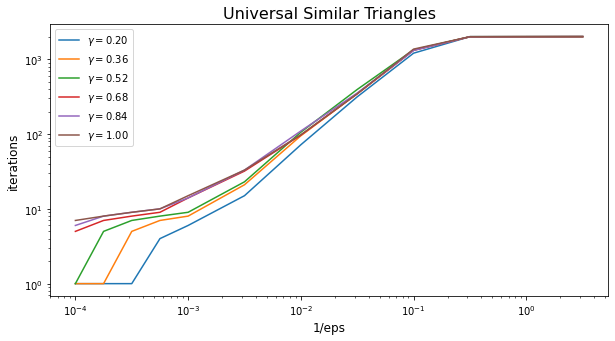

In [200]:
plt.figure(figsize = (10, 5))
for gamma in gammas:
    results = init_results[gamma]
    dual_gaps = np.array([result['eps_abs'] for result in results])
    iters = np.array([result['history']['inner_iters'][-1] for result in results])
    plt.plot(1/dual_gaps, iters, label='$\gamma=${:.2f}'.format(gamma))
    plt.title('Universal Similar Triangles', fontsize = 16)
    plt.xlabel('1/eps', fontsize = 12)
    plt.ylabel('iterations', fontsize = 12)
    plt.xscale('log')
    plt.yscale('log')
plt.legend();

## Universal Gradient Descent

In [17]:
epsilons = np.hstack([np.logspace(4, 3, 5)[:-1],np.logspace(3,1.5,7)])[::-1]
epsilons

array([   31.6227766 ,    56.23413252,   100.        ,   177.827941  ,
         316.22776602,   562.34132519,  1000.        ,  1778.27941004,
        3162.27766017,  5623.4132519 , 10000.        ])

In [18]:
#weighted t added
assert(model.mu == 0.25)
max_iter = 1000
init_results = {}

for gamma in gammas:
    print('Gamma = {:.2f}'.format(gamma))
    t_start = gamma * t_free_flow + (1 - gamma) * t_star
    results = []
    for index, eps_abs in enumerate(epsilons):
        print('eps_abs =', eps_abs)
        solver_kwargs = {'eps_abs': eps_abs,
                         'max_iter': max_iter, 'stop_crit': 'dual_gap',
                         'verbose' : True, 'verbose_step': 4000, 'save_history' : True}
        tic = time.time()
        result = model.find_equilibrium(
            solver_name = 'ugd',
            composite = True,
            solver_kwargs = solver_kwargs,
            t_start=t_start,
        )
        toc = time.time()
        print('Elapsed time: {:.0f} sec'.format(toc - tic))
        print('Time ratio =', np.max(result['times'] / graph_data['graph_table']['free_flow_time']))
        print('Flow excess =', np.max(result['flows'] / graph_data['graph_table']['capacity']) - 1, end = '\n\n')

        result['eps_abs'] = eps_abs
        result['elapsed_time'] = toc - tic
        results.append(result)
    init_results[gamma] = results
    print('-'*50)

Gamma = 0.20
eps_abs = 31.622776601683793
Composite optimization...
Oracles created...
Universal gradient descent method...
Given point is used as t_start...
Primal_init = 1.28701e+06
Dual_init = -1.28475e+06
Duality_gap_init = 2254.71

Result: iterations number exceeded
Total iters: 1000
Primal_func_value = 1.28607e+06
Dual_func_value = -1.2859e+06
Duality_gap = 162.63
Duality_gap / Duality_gap_init = 0.0721292
Oracle elapsed time: 68 sec
Elapsed time: 69 sec
Time ratio = 3.0222397369576144
Flow excess = 1.0675176460468139

eps_abs = 56.23413251903491
Composite optimization...
Oracles created...
Universal gradient descent method...
Given point is used as t_start...
Primal_init = 1.28701e+06
Dual_init = -1.28475e+06
Duality_gap_init = 2254.71

Result: iterations number exceeded
Total iters: 1000
Primal_func_value = 1.28605e+06
Dual_func_value = -1.28596e+06
Duality_gap = 95.0093
Duality_gap / Duality_gap_init = 0.0421382
Oracle elapsed time: 68 sec
Elapsed time: 69 sec
Time ratio = 3.0


Result: success
Total iters: 52
Primal_func_value = 1.28615e+06
Dual_func_value = -1.28559e+06
Duality_gap = 554.081
Duality_gap / Duality_gap_init = 0.110518
Oracle elapsed time: 3 sec
Elapsed time: 3 sec
Time ratio = 2.801659608386695
Flow excess = 1.1268822975517923

eps_abs = 1000.0
Composite optimization...
Oracles created...
Universal gradient descent method...
Given point is used as t_start...
Primal_init = 1.28722e+06
Dual_init = -1.2822e+06
Duality_gap_init = 5013.49

Result: success
Total iters: 16
Primal_func_value = 1.28626e+06
Dual_func_value = -1.28526e+06
Duality_gap = 997.156
Duality_gap / Duality_gap_init = 0.198895
Oracle elapsed time: 1 sec
Elapsed time: 1 sec
Time ratio = 2.709809569794421
Flow excess = 1.1890718157181577

eps_abs = 1778.2794100389228
Composite optimization...
Oracles created...
Universal gradient descent method...
Given point is used as t_start...
Primal_init = 1.28722e+06
Dual_init = -1.2822e+06
Duality_gap_init = 5013.49

Result: success
Total i


Result: iterations number exceeded
Total iters: 1000
Primal_func_value = 1.28628e+06
Dual_func_value = -1.28518e+06
Duality_gap = 1102.17
Duality_gap / Duality_gap_init = 0.0583626
Oracle elapsed time: 68 sec
Elapsed time: 69 sec
Time ratio = 2.542042996420495
Flow excess = 1.1971896536908266

eps_abs = 56.23413251903491
Composite optimization...
Oracles created...
Universal gradient descent method...
Given point is used as t_start...
Primal_init = 1.2907e+06
Dual_init = -1.27182e+06
Duality_gap_init = 18885

Result: iterations number exceeded
Total iters: 1000
Primal_func_value = 1.2862e+06
Dual_func_value = -1.28554e+06
Duality_gap = 660.486
Duality_gap / Duality_gap_init = 0.0349742
Oracle elapsed time: 68 sec
Elapsed time: 69 sec
Time ratio = 2.697627371635914
Flow excess = 1.1539004441594116

eps_abs = 100.0
Composite optimization...
Oracles created...
Universal gradient descent method...
Given point is used as t_start...
Primal_init = 1.2907e+06
Dual_init = -1.27182e+06
Duality_


Result: success
Total iters: 63
Primal_func_value = 1.28628e+06
Dual_func_value = -1.28529e+06
Duality_gap = 989.524
Duality_gap / Duality_gap_init = 0.0321651
Oracle elapsed time: 4 sec
Elapsed time: 4 sec
Time ratio = 2.5647912503731107
Flow excess = 1.1821603782505954

eps_abs = 1778.2794100389228
Composite optimization...
Oracles created...
Universal gradient descent method...
Given point is used as t_start...
Primal_init = 1.2934e+06
Dual_init = -1.26263e+06
Duality_gap_init = 30763.9

Result: success
Total iters: 20
Primal_func_value = 1.28646e+06
Dual_func_value = -1.28469e+06
Duality_gap = 1766.02
Duality_gap / Duality_gap_init = 0.0574057
Oracle elapsed time: 1 sec
Elapsed time: 1 sec
Time ratio = 2.3738790879155345
Flow excess = 1.2553015467574853

eps_abs = 3162.2776601683795
Composite optimization...
Oracles created...
Universal gradient descent method...
Given point is used as t_start...
Primal_init = 1.2934e+06
Dual_init = -1.26263e+06
Duality_gap_init = 30763.9

Result:

In [20]:
with open('init_results/beckmann_anaheim_ugd_res_1000.pickle', 'wb') as f:
    pickle.dump(init_results, f)

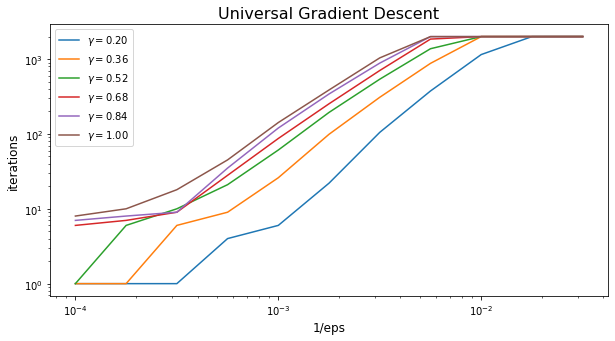

In [212]:
plt.figure(figsize = (10, 5))
for gamma in gammas:
    results = init_results[gamma]
    dual_gaps = np.array([result['eps_abs'] for result in results])
    iters = np.array([result['history']['inner_iters'][-1] for result in results])
    plt.plot(1/dual_gaps, iters, label='$\gamma=${:.2f}'.format(gamma))
    plt.title('Universal Gradient Descent', fontsize = 16)
    plt.xlabel('1/eps', fontsize = 12)
    plt.ylabel('iterations', fontsize = 12)
    plt.xscale('log')
    plt.yscale('log')
plt.legend();

## Weighted Dual Averages

### Composite optimization

In [21]:
assert(model.mu == 0.25)
max_iter = 1000

init_results = {}

for gamma in gammas:
    print('Gamma = {:.2f}'.format(gamma))
    t_start = gamma * t_free_flow + (1 - gamma) * t_star
    solver_kwargs = {'max_iter' : max_iter, 'stop_crit': 'max_iter',
                     'verbose': True, 'verbose_step': 4000, 'save_history': True}
    tic = time.time()
    result = model.find_equilibrium(solver_name = 'wda', composite = True, solver_kwargs = solver_kwargs, 
                                    t_start=t_start)
    toc = time.time()
    init_results[gamma] = result
    print('Elapsed time: {:.0f} sec'.format(toc - tic))
    print('Time ratio =', np.max(result['times'] / graph_data['graph_table']['free_flow_time']))
    print('Flow excess =', np.max(result['flows'] / graph_data['graph_table']['capacity']) - 1)
    print('-'*50)

result['elapsed_time'] = toc - tic

Gamma = 0.20
Composite optimization...
Oracles created...
Weighted dual averages method...
Given point is used as t_start...
Primal_init = 1.28701e+06
Dual_init = -1.28475e+06
Duality_gap_init = 2254.71

Result: success
Total iters: 1000
Primal_func_value = 1.28603e+06
Dual_func_value = -1.28603e+06
Duality_gap = 4.49039
Duality_gap / Duality_gap_init = 0.00199156
Oracle elapsed time: 30 sec
Elapsed time: 31 sec
Time ratio = 3.2706751514771883
Flow excess = 0.9867224610185392
--------------------------------------------------
Gamma = 0.36
Composite optimization...
Oracles created...
Weighted dual averages method...
Given point is used as t_start...
Primal_init = 1.28722e+06
Dual_init = -1.2822e+06
Duality_gap_init = 5013.49

Result: success
Total iters: 1000
Primal_func_value = 1.28603e+06
Dual_func_value = -1.28602e+06
Duality_gap = 9.5964
Duality_gap / Duality_gap_init = 0.00191412
Oracle elapsed time: 30 sec
Elapsed time: 30 sec
Time ratio = 3.2462258755971667
Flow excess = 0.993098

In [13]:
with open('init_results/beckmann_anaheim_wda_res_1000.pickle', 'wb') as f:
    pickle.dump(init_results, f)

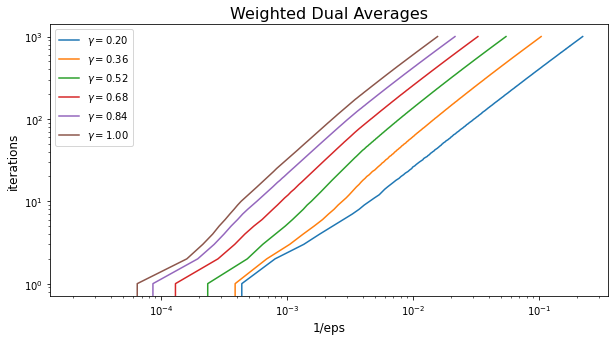

In [217]:
plt.figure(figsize = (10, 5))
for gamma in gammas:
    result = init_results[gamma]
    dual_gaps = np.array(result['history']['dual_gap'])
    iters = np.array(result['history']['iter'])
    plt.plot(1 / dual_gaps, iters, label='$\gamma=${:.2f}'.format(gamma))
    plt.xlabel('1/eps', fontsize = 12)
    plt.ylabel('iterations', fontsize = 12)
    plt.title('Weighted Dual Averages', fontsize = 16)
    plt.xscale('log')
    plt.yscale('log')
plt.legend();

## Plots

In [223]:
with open('init_results/beckmann_anaheim_fwm_res_1000.pickle', 'rb') as f:
    fwm_results = pickle.load(f) 
    
with open('init_results/beckmann_anaheim_ustm_res_1000.pickle', 'rb') as f:
    ustm_results = pickle.load(f)
    
with open('init_results/beckmann_anaheim_ugd_res_1000.pickle', 'rb') as f:
    ugd_results = pickle.load(f)
    
with open('init_results/beckmann_anaheim_wda_res_1000.pickle', 'rb') as f:
    wda_results = pickle.load(f)

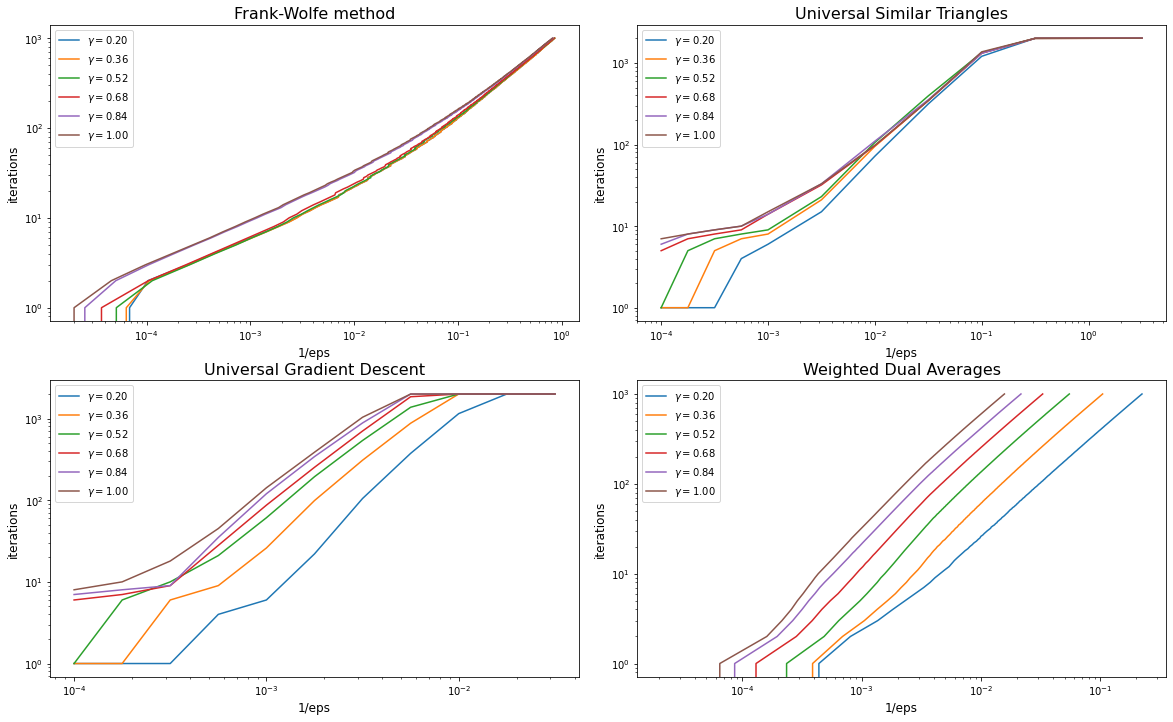

In [241]:
fig, axs = plt.subplots(2, 2, figsize=(20, 12))
plt.subplots_adjust(hspace=0.2, wspace=0.11)
for gamma in gammas:
    result = fwm_results[gamma]
    dual_gaps = np.array(result['history']['dual_gap'])
    iters = np.array(result['history']['iter'])
    axs[0][0].plot(1/dual_gaps, iters, label='$\gamma=${:.2f}'.format(gamma))
    axs[0][0].set_title('Frank-Wolfe method', fontsize = 16)
    axs[0][0].set_xlabel('1/eps', fontsize = 12)
    axs[0][0].set_ylabel('iterations', fontsize = 12)
    axs[0][0].set_xscale('log')
    axs[0][0].set_yscale('log')
    axs[0][0].legend()
    
for gamma in gammas:
    results = ustm_results[gamma]
    dual_gaps = np.array([result['eps_abs'] for result in results])
    iters = np.array([result['history']['inner_iters'][-1] for result in results])
    axs[0][1].plot(1/dual_gaps, iters, label='$\gamma=${:.2f}'.format(gamma))
    axs[0][1].set_title('Universal Similar Triangles', fontsize = 16)
    axs[0][1].set_xlabel('1/eps', fontsize = 12)
    axs[0][1].set_ylabel('iterations', fontsize = 12)
    axs[0][1].set_xscale('log')
    axs[0][1].set_yscale('log')
    axs[0][1].legend()
    
for gamma in gammas:
    results = ugd_results[gamma]
    dual_gaps = np.array([result['eps_abs'] for result in results])
    iters = np.array([result['history']['inner_iters'][-1] for result in results])
    axs[1][0].plot(1/dual_gaps, iters, label='$\gamma=${:.2f}'.format(gamma))
    axs[1][0].set_title('Universal Gradient Descent', fontsize = 16)
    axs[1][0].set_xlabel('1/eps', fontsize = 12)
    axs[1][0].set_ylabel('iterations', fontsize = 12)
    axs[1][0].set_xscale('log')
    axs[1][0].set_yscale('log')
    axs[1][0].legend()
    
for gamma in gammas:
    result = wda_results[gamma]
    dual_gaps = np.array(result['history']['dual_gap'])
    iters = np.array(result['history']['iter'])
    axs[1][1].plot(1 / dual_gaps, iters, label='$\gamma=${:.2f}'.format(gamma))
    axs[1][1].set_xlabel('1/eps', fontsize = 12)
    axs[1][1].set_ylabel('iterations', fontsize = 12)
    axs[1][1].set_title('Weighted Dual Averages', fontsize = 16)
    axs[1][1].set_xscale('log')
    axs[1][1].set_yscale('log')
    axs[1][1].legend();

In [218]:
%matplotlib inline
from matplotlib import pyplot as plt
import pickle
import numpy as np
beckmann_save = 'init_results/'

In [219]:
inv_eps_grid = np.logspace(-3, -1, 3)
method_results = {}

In [220]:
for method in ['fwm', 'wda']:
    with open(f'init_results/beckmann_anaheim_{method}_res_1000.pickle', 'rb') as f:
        load_res = pickle.load(f)
    gamma_eps_iters = {}
    for gamma in load_res:
        dual_gaps = np.array(load_res[gamma]['history']['dual_gap'])
        inv_eps = (1 / dual_gaps).reshape(-1, 1)
        idx = (np.abs(np.repeat(inv_eps_grid.reshape(1, -1), len(inv_eps), axis=0) - inv_eps)).argmin(axis=0)
        if 'inner_iters' in load_res[gamma]['history']:
            iters = np.array([result['history']['inner_iters'][-1] for result in load_res[gamma]])
        else:
            iters = np.array(load_res[gamma]['history']['iter'])
        gamma_eps_iters[gamma] = iters[idx] 
    method_results[method] = gamma_eps_iters

In [221]:
for method in ['ustm', 'ugd']:
    with open(f'init_results/beckmann_anaheim_{method}_res_1000.pickle', 'rb') as f:
        load_res = pickle.load(f)
    gamma_eps_iters = {}
    for gamma in load_res:
        dual_gaps = np.array([result['eps_abs'] for result in load_res[gamma]])
        inv_eps = (1 / dual_gaps).reshape(-1, 1)
        idx = (np.abs(np.repeat(inv_eps_grid.reshape(1, -1), len(inv_eps), axis=0) - inv_eps)).argmin(axis=0)
        if 'inner_iters' in load_res[gamma][0]['history']:
            iters = np.array([result['history']['inner_iters'][-1] for result in load_res[gamma]])
        else:
            iters = np.array(load_res[gamma]['history']['iter'])
        gamma_eps_iters[gamma] = iters[idx] 
    method_results[method] = gamma_eps_iters

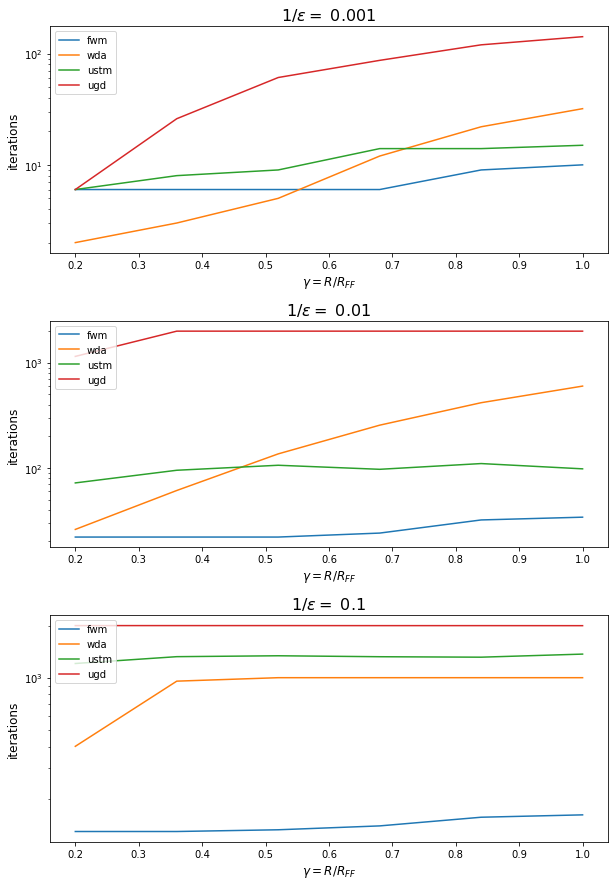

In [222]:
fig, axs = plt.subplots(len(inv_eps_grid), 1, figsize=(10, 15))
plt.subplots_adjust(hspace=0.3)
for i, eps in enumerate(inv_eps_grid):
    for method in method_results:
        gammas = list(method_results[method].keys())
        iters = np.array(list(method_results[method].values()))[:, i]
        axs[i].plot(gammas, iters, label=method)
        axs[i].set_yscale('log')
        axs[i].legend(loc=2)
        axs[i].set_ylabel('iterations', fontsize=12)
        axs[i].set_xlabel('$\gamma = R/R_{FF}$', fontsize=12)
    axs[i].set_title('$1/\epsilon =$ {}'.format(eps), fontsize=16)

This set of plots (as well as previous one) indicates that studied methods differ in terms of stability to initialization.<br/>
There is a significant impact of a starting point on UGD and WDA, i.e. the number of iterations needed for a certain duality gap highly varies for different values of $\gamma$ in case of these methods. Yet for FWM and USTM the dependence between convergence rate and initialization is barely visible. <br/>
In the nutshell, our results reveal that UGD and WDA are more unstable to initialization than FWM and USTM.